<hr style='height:3pt'>

# Meme Caption Generator
## Data Processing
Anthony Rentsch, Nicholas Stern, Lipika Ramaswamy

<hr style='height:3pt'>

In this notebook we do all of the necessary data processing for the Meme Generator data that we scraped using the `meme_generator_scraper.py` file. We follow the lead of the paper [Dank Learning](https://arxiv.org/pdf/1806.04510.pdf) throughout. We do make some decisions that cut down on the size of our dataset, but we feel that those are okay because training our model takes a long time even with a smaller subset.

This notebook is set up as follows:

0. [**Set up**](#setup)
1. [**Load GloVe embeddings**](#glove)
2. [**Clean captions and labels**](#cleaning)
3. [**Create word mappings**](#finalmap)


<hr style='height:3pt'>

# 0. Set up<a name="setup"></a>

<hr style='height:3pt'>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
import nltk
#nltk.download('words')
from collections import Counter
from itertools import chain
import pickle
from pickle_utils import pickle_load, pickle_dump
from loadGlove import loadGloveModel

In [2]:
captions = pd.read_csv("captions.csv", error_bad_lines=False, warn_bad_lines=False)
print("Number of observations: {}.".format(captions.shape[0]))
captions.sample(10, random_state=22)

Number of observations: 155392.


,image,above_text,below_text
54053,My Precious Gollum,Hello TARA...,HELLO PRECIOUS
67160,Ecstatic Michael Phelps,tHERE'S A POT OF THE STUFF?,i LOVE POT.
49626,katt williams shocked,What,you actually thought you were getting rp?
9727,Okay Guy,TOOK AN ARROW TO THE KNEE,OKAY..
22047,Rich Men Laughing,and then we told them,their health insurance premiums wouldnt go up
150193,kim jong un,they see me rulin',they hatin'
121915,The Olympic Queen,vodka,NaN
132328,Paperclip,it looks like you're having trouble,fapping to this meme
120444,Honey BooBoo,happy birthday,ali boo boo
15655,Not sure if troll,not sure if nicki minaj,or a mutant from mortal combat


Notice that our captions are split up into two pieces: the `above_text`, the piece of the meme caption that is located above the base image, and the `below_text`, the piece of the caption that is located below the base image. This follows from a recommendation in the original Dank Learning paper that we follow to predict both parts of the caption rather than the full concatenated caption.

In [3]:
# create small subsample
# num_labels = 100
# random_labels = list(np.random.choice(captions.image.unique(), num_labels))
# captions = captions[captions['image'].isin(random_labels)].reset_index(drop=True)

<hr style='height:3pt'>

# 1. Load GloVe word embeddings <a name="glove"></a>

<hr style='height:3pt'>

We downloaded the one of the pre-trained Global Vectors for Word Representation embeddings (i.e., GloVe embeddings) from Stanford NLP's [website](https://nlp.stanford.edu/projects/glove/). We use the vectors trained on a Common Cralw dataset with 42 billion tokens and a vocabulary size of 1.9 million words. The vectors, essentially a latent representation of each of the 1.9 million words, are 300-dimensional. 

We wrote a helper function (found in `loadGlove.py`) to turn the downloaded .txt file into two helpful objects:
- a matrix where each row corresponds to the GloVe embedding for one word
- a dictionary that maps words to their index in the embeddings matrix

In [4]:
glove_objs = loadGloveModel("glove.txt")

In [5]:
glove_index_dict = glove_objs[0]
glove_embedding_weights = glove_objs[1]

In [6]:
len(glove_index_dict), glove_embedding_weights.shape

(1917494, (1917494, 300))

In [7]:
# pickle_dump(glove_objs, "glove_objs.pkl")
# glove_objs = pickle_load("glove_objs.pkl")

<hr style='height:3pt'>

# 2. Clean captions and labels <a name="cleaning"></a>

Since we are scraping plain text that is input by users of Meme Generator, there is a lot of cleaning to be done. The following sub-sections perform various cleaning operations, ranging from discarding images with missing image labels to filtering out captions that contain offensive words or phrases.

<hr style='height:3pt'>

### a. Remove rows when there are NaNs in the captions or labels

In [8]:
np.sum(pd.isna(captions))

image           13
above_text    6137
below_text    7199
dtype: int64

In [9]:
captions.iloc[np.where(pd.isna(captions.image))]

,image,above_text,below_text
18546,NaN,several people get up and leave as they can se...,NaN
43899,NaN,teacher is even later than you,NaN
57525,NaN,Ekki málið :),NaN
100719,NaN,Ert þú starfsmaður þarna eða eigandi?,NaN
100723,NaN,uppiskorpi!!!,NaN
100725,NaN,Eða bara eldisfiskur. LOL.,NaN
100728,NaN,Takk kærlega fyrir þetta :),NaN
105241,NaN,makes us strong,NaN
105243,NaN,makes us strong,NaN
114690,NaN,Nei þá nærðu í rauðvín,NaN


In [10]:
captions = captions[pd.notnull(captions.image)]
captions = captions.replace(np.nan, '', regex=True)

In [11]:
np.sum(pd.isna(captions))

image         0
above_text    0
below_text    0
dtype: int64

### b. Convert all captions and labels to lowercase

In [12]:
captions['image'] = captions['image'].str.lower()
captions['above_text'] = captions['above_text'].str.lower()
captions['below_text'] = captions['below_text'].str.lower()

In [13]:
captions.sample(10, random_state=33)

,image,above_text,below_text
148743,bender popular,todos se iban a paro,la usm solo quería ser popular
60086,uncle dolan pls,clovhy pls,
81607,lawn chair blown over,cerberus earthquake 2012,we will rebuild
79323,pizzeria los hijos de puta,y monsters university?,para cuando monsters university?!
42541,liberal douche garofalo,overregulates everything into complete disfunc...,"defends it as ""the new normal"""
6074,joker mind loss,a girl kiss a girl in public and no one bats a...,a boy kiss a boy in public and everyone loses ...
152361,over obsessive girlfriend,why,is sleep more important than me kim?
142516,tony horton,recovery week,it's a beautiful thing!
42871,mens wearhouse,you're gonna like how the site looks,i guarantee it
7923,butthurt dweller,talk shit on internet,feel superior


### c. Remove rows with non-English or offensive words

We noticed that many captions were in other languages, particularly Spanish and Russian. We wish to get rid of these in our final dataset, so we filter out all captions with words that do not appear in the words in GloVe (which are all English words). This is a rather harsh criteria and we do remove some captions with English words that simply do not show up in GloVe.

Additionally, we wish to filter out as much offensive content as we can. We noticed that many of the memes from Meme Generator contained hateful content and we would not like to perpetuate this type of content in our project. This is an extension recommended by the authors of Dank Learning.

We filter out words in our training set that contain any words from a [list](https://gist.github.com/jamiew/1112488) of "bad words" compiled as a part of Google's "What Do You Love" project. The idea to filter out words from this list comes from a [paper](https://www.usenix.org/system/files/conference/foci17/foci17-paper-nithyanand.pdf) which attempted to measure offensive speech in political discourse on Reddit.

**Non-English words**

In [14]:
glove_words = set(list(glove_index_dict.keys()))

In [15]:
nonenglishinds = []
i = 0
for ind, cap in enumerate(captions.above_text + " " + captions.below_text):
    for word in cap.split():
        if word not in glove_words:
            nonenglishinds.append(ind)

nonenglishinds = list(set(nonenglishinds))           
print("{} observations deleted because they contain non-English words.".format(len(nonenglishinds)))

72453 observations deleted because they contain non-English words.


In [16]:
captions = captions.drop(captions.index[nonenglishinds]).reset_index(drop=True)

**Offensive words**

In [17]:
badwords = []
i = 1
google_wdyl_path = "google_twunter_lol.txt"
with open(google_wdyl_path, 'r') as f:
    for line in f:
        for word in line.split(":"):
            if i % 2 == 0:
                badwords.append(word.replace('"', ""))
            i += 1
badwords.pop()

'}'

In [18]:
badwordinds = []
i = 0
for ind, cap in enumerate(captions.above_text + " " + captions.below_text):
    for word in cap.split():
        if word in badwords:
            badwordinds.append(ind)
print("{} observations deleted because they contain bad words.".format(len(badwordinds)))

10641 observations deleted because they contain bad words.


In [19]:
captions = captions.drop(captions.index[badwordinds]).reset_index(drop=True)

### d. Remove other bad rows

Now, we combine `above_text` and `below_text` here with appropriate breakpoint tokens. This will be re-used later when we tokenize the captions. For now, this lets us filter out captions that are too long.

In [20]:
breakpoint_captions = "<sos> " + captions.above_text + " <break> " + captions.below_text + " <eos>"

We limit to caption length to under some reasonable upper bound for a meme caption. We set that threshold to 20. For many, the scrape just got messed up and appended many captions into one observation. We simply discard these rows, which are a small subset of our data.

In [21]:
longinds = []
maxcaplen = 20
howmany = 0
for i, cap in enumerate(breakpoint_captions):
    splitcap = cap.split()
    if len(splitcap) > maxcaplen:
        longinds.append(i)
        howmany += 1
captions = captions.drop(captions.index[longinds]).reset_index(drop=True)
breakpoint_captions = breakpoint_captions.drop(breakpoint_captions.index[longinds])
print("Deleted {} rows for being too long.".format(howmany))

Deleted 3525 rows for being too long.


### e. Clean miscellaneous bad labels

In [22]:
captions['image'] = captions['image'].str.replace("third",'3rd ')
captions['image'] = captions['image'].str.replace("3rd -world",'3rd world')

In [23]:
print("After all of this cleaning we are left with {} observations.".format(captions.shape[0]))

After all of this cleaning we are left with 70122 observations.


<hr style='height:3pt'>

# 3. Create word mappings<a name="finalmap"></a>

Finally, we go ahead and create the data objects we need to train our model. This includes:

- word2idx and idx2word mappings for the words in our vocabulary
- embeddings matrix for the words in our vocabulary
- tokenized and padded captions and image labels

The structure for this section is borrowed from Harvard IACS 2019 ComputeFest [code](https://github.com/Harvard-IACS/2019-computefest/blob/master/Friday/data_preprocess.ipnb.ipynb).

<hr style='height:3pt'>

### a. Vocabulary

In [24]:
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return list(vocab), vocabcount

In [25]:
vocab, vocabcount = get_vocab(list(captions.image) + list(captions.above_text) + list(captions.below_text))

In [26]:
print("Vocabulary size: {}".format(len(vocab)))

Vocabulary size: 36706


### b. word2idx and idx2word mappings

In [27]:
sos = 1
eos = 0  
br = 2
start_idx = br+1 

word2idx = {word: idx+start_idx for idx, word in enumerate(vocab)}
word2idx['<sos>'] = sos
word2idx['<eos>'] = eos
word2idx['<break>'] = br

idx2word = {ix: word for word, ix in word2idx.items()}

### c. Form embedding matrix

For the words in our observed data, store the GloVe embeddings in a matrix. If the word didn't exist in GloVe, initialize it with uniform weights. This should not be the case since we filter out words that don't exist in GloVe, but we do this to be safe.

In [28]:
vocab_size = len(word2idx)
embedding_dim = 300
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 
embedding = np.random.uniform(low=-scale, high=scale, size=shape)

c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w))
    if g is None and w.startswith('#'):
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1

### d. Create final data

These next cells create what should be the input data we need. This includes right padded tokenzied captions and image labels.

In [29]:
def rpad(x, maxlen=maxcaplen, eos=eos):
    assert maxlen >= 0
    if maxlen == 0:
        return [eos]
    n = len(x)
    if n > maxlen:
        x = x[-maxlen:]
        n = maxlen
    return x + [eos]*(maxlen-n)

In [30]:
tokenized_captions = [rpad([word2idx[token] for token in cap.split()]) for cap in breakpoint_captions]                  

In [31]:
tokenized_images = [[word2idx[token] for token in cap.split()] for cap in captions.image]   
tokenized_padded_images = [rpad([word2idx[token] for token in cap.split()]) for cap in captions.image]   

Quick sanity check to make sure these were all created appropriately.

In [32]:
print("IMAGE LABEL: ", captions.image[24])
print("TOKENIZED IMAGE LABEL: ", tokenized_images[24])
print("CAPTION: ", captions.above_text[24] + " " + captions.below_text[24])
print("CAPTION WITH BREAKPOINTS: ", breakpoint_captions[24])
print("TOKENIZED CAPTION: ", tokenized_captions[24])
print("CAPTION LENGTH: ", len(tokenized_captions[24]))
for token in tokenized_captions[24]:
    print(idx2word[token])

IMAGE LABEL:  y u no
TOKENIZED IMAGE LABEL:  [92, 72, 21]
CAPTION:  justin bieber y u no dead
CAPTION WITH BREAKPOINTS:  <sos> justin bieber <break> y u no dead <eos>
TOKENIZED CAPTION:  [1, 304, 446, 2, 92, 72, 21, 176, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
CAPTION LENGTH:  20
<sos>
justin
bieber
<break>
y
u
no
dead
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>
<eos>


### e. Validate findings

Max caption length: 20, index of longest caption: 67
Caption: <sos> memegenerator <break> y u no let me see what memes i have created and what memes i like <eos>


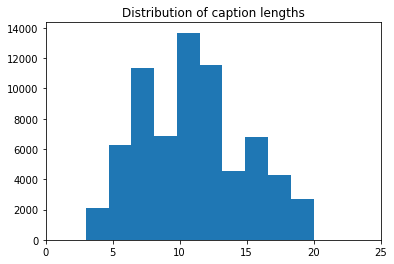

In [33]:
maxlen = 0
longcap = ""
ind = 0
lens = []
for i, cap in enumerate(breakpoint_captions):
    splitcap = cap.split()
    lens.append(len(splitcap))
    if len(splitcap) > maxlen:
        maxlen = len(splitcap)
        longcap = cap
        ind = i
print("Max caption length: {}, index of longest caption: {}\nCaption: {}".format(maxlen, ind, longcap))
plt.hist(lens)
plt.xlim([0, 25])
plt.title("Distribution of caption lengths");

### f. Save

In [34]:
captions_copy = captions.copy()

In [35]:
def strip_junk(x):
    '''
    Get rid of bad punctuation and spaces in the image labels.
    '''
    illegal = ["?", "'", " /", "[", "]", ".", "á", " -", "*", "/", "!", 
               "ñ", "í", "(", ")", "$", "\"", "`", ":", ";"]
    end_illegal = [' ', '-']
    impute_chars = ['- ',' ', '_']
    
    for char in end_illegal:
        while x[-1] == char:  # strip off illegal end characters
            x = x[:-1]
    
    for char in illegal:
        if char in x:  # strip off overall illegal characters
            x = x.replace(char, "")
        
    for char in impute_chars: # impute certain characters
        x = x.replace(char, "-")
    return x + ".jpg"  

In [36]:
# fill out rest of captions.csv
captions_copy['file_path'] = captions_copy['image'].apply(strip_junk)
captions_copy['full_caption'] = breakpoint_captions
captions_copy['full_padded_caption'] = pd.Series((cap for cap in tokenized_captions))
captions_copy['tokenized_label'] = tokenized_images
captions_copy['tokenized_padded_label'] = tokenized_padded_images
captions_copy['image'] = captions_copy['image'].apply(lambda x: x.strip(' '))

In [37]:
out_file = "full_clean_processed_data.pkl"
out_objs = (embedding, idx2word, word2idx, captions_copy)
pickle_dump(out_objs, out_file)

writing total_bytes=106654863...
writing bytes [0, 106654863)... done.


---